In [ ]:
import kagglehub
orvile_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/brain-cancer-mri-dataset')
print('Data source import complete.')

Data source import complete.


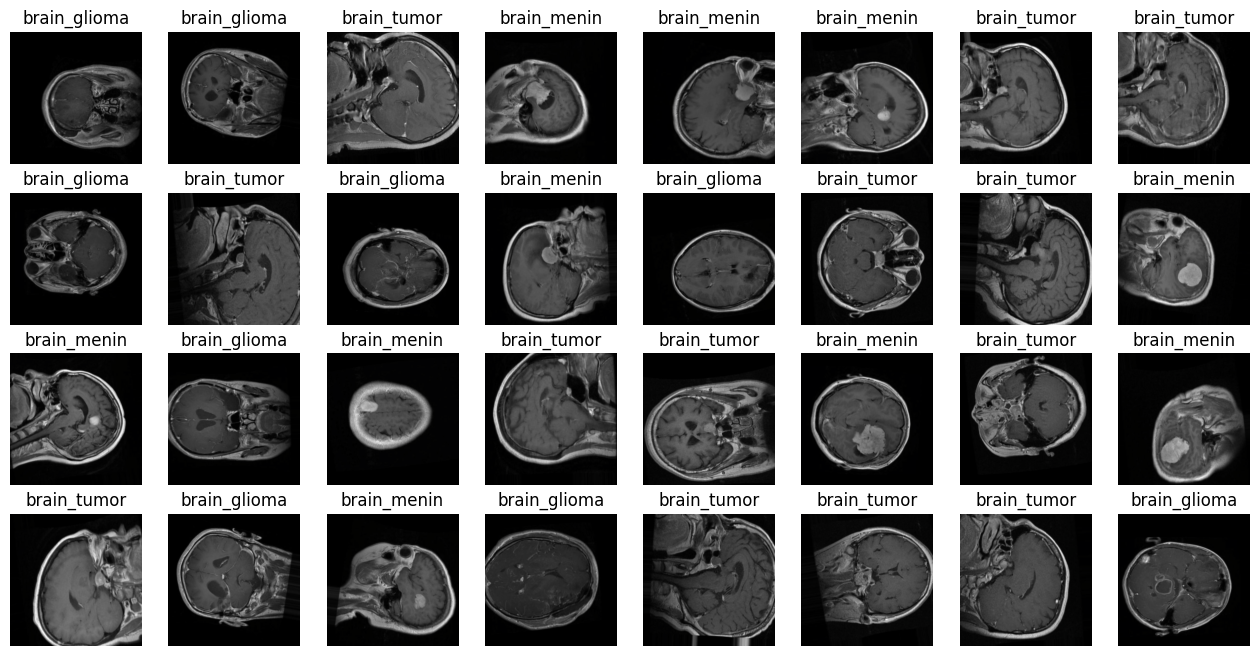

In [6]:
LABELS =  ['brain_tumor', 'brain_glioma', 'brain_menin']
transformed_data = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
dataset = torchvision.datasets.ImageFolder(data_dir,transform=transformed_data)
train_split =  int(len(dataset) * 0.8)
test_split = len(dataset) - train_split
train_data,test_data = torch.utils.data.random_split(dataset, lengths=[train_split,test_split])
BATCH_SIZE = 32
epochs = 10
learning_rate = 0.001
train_dataloader = torch.utils.data.DataLoader(train_data,BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,BATCH_SIZE,shuffle=False)
def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    image = image * std + mean
    return np.clip(image,0,1)
images,labels = next(iter(train_dataloader))
fig,axs = plt.subplots(4,8,figsize=(16,8))
for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.con1 = nn.Conv2d(3, 32, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)

        self.con2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)

        self.con3 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)

        self.con4 = nn.Conv2d(128,228,kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm2d(228)
        self.pool4 = nn.MaxPool2d(2,2)


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*16*228,512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self,x):
        x = self.pool1(F.relu(self.bn1(self.con1(x))))
        x = self.pool2(F.relu(self.bn2(self.con2(x))))
        x = self.pool3(F.relu(self.bn3(self.con3(x))))
        x = self.pool4(F.relu(self.bn4(self.con4(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()
model.to(device)

Net(
  (con1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con4): Conv2d(128, 228, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(228, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)
for epoch in range(epochs):
    running_loss = 0.0
    for i,(images,labels) in enumerate(train_dataloader):
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

Epoch [1/10], Loss: 2.2669
Epoch [2/10], Loss: 0.5073
Epoch [3/10], Loss: 0.3457
Epoch [4/10], Loss: 0.2859
Epoch [5/10], Loss: 0.2468
Epoch [6/10], Loss: 0.2171
Epoch [7/10], Loss: 0.1827
Epoch [8/10], Loss: 0.1653
Epoch [9/10], Loss: 0.1566
Epoch [10/10], Loss: 0.1351


In [9]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    y_test = []
    pred = []
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs,dim=1)
        y_test.extend(labels.cpu().numpy())
        pred.extend(preds.cpu().numpy())
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        loss = criterion(outputs,labels)
print(f'Accuracy: {correct * 100 / total}')


Accuracy: 71.03960396039604


In [10]:
print(classification_report(y_test,pred))


              precision    recall  f1-score   support

           0       0.97      0.71      0.82       410
           1       0.53      0.96      0.69       391
           2       0.95      0.47      0.63       411

    accuracy                           0.71      1212
   macro avg       0.82      0.71      0.71      1212
weighted avg       0.82      0.71      0.71      1212



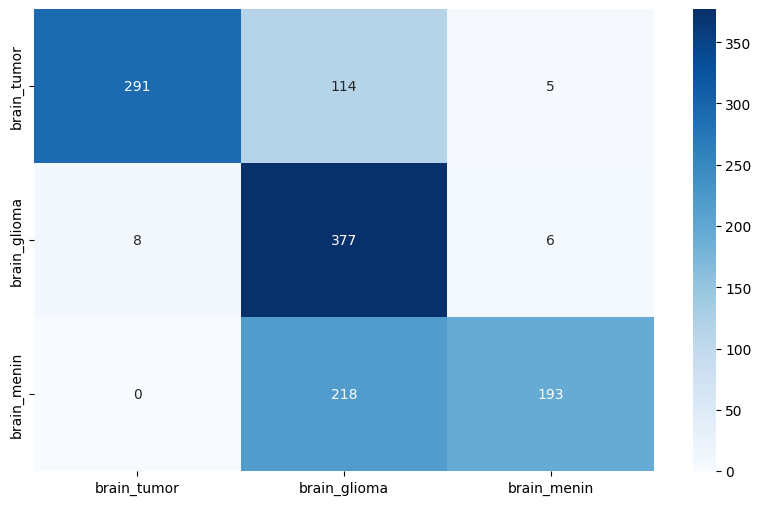

In [11]:
def plot_confusion_matrix(y_test,pred):
    cm = confusion_matrix(y_test, pred)
    return sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",xticklabels=LABELS,yticklabels=LABELS)
plt.figure(figsize=(10,6))
plot_confusion_matrix(y_test, pred)
plt.show()

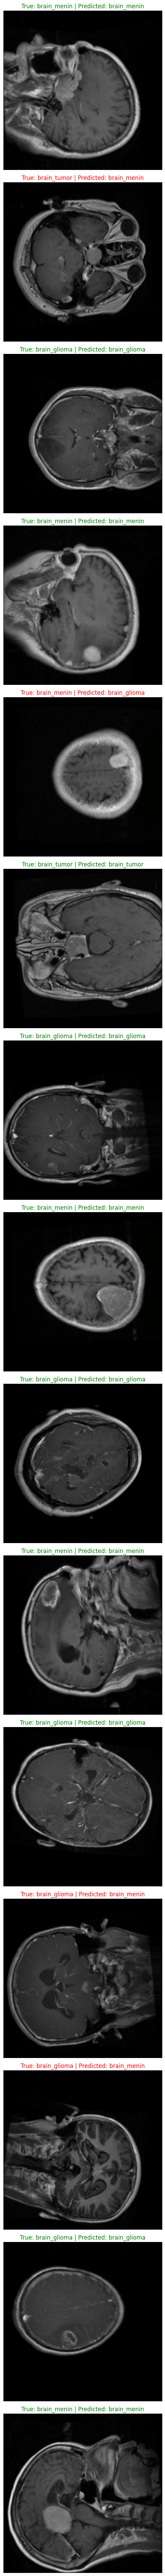

In [14]:
rand_indices = np.random.choice(len(pred), size=min(15,len(pred)),replace=False)
plt.figure(figsize=(10, 5 * len(rand_indices)))
for i, index in enumerate(rand_indices):
    image = img_inv(test_data[index][0])
    plt.subplot(len(rand_indices),1, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    predicted_class = dataset.classes[pred[index]]
    true_class = dataset.classes[y_test[index]]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()